<a href="https://colab.research.google.com/github/sreenesh-reddy/Infosys-Springboard-Internship/blob/main/CNNModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn #Imports PyTorch's neural network module, which includes classes for building and training neural networks.
#used while applying deep learning
import torch.optim as optim #implementing optimization algorithms like SGD and Adam
from torchvision import datasets, transforms #for preprocessing
from torch.utils.data import DataLoader #load datasets Tin batches for training and testing
import matplotlib.pyplot as plt #Interactive and animated visualizations
from sklearn.metrics import confusion_matrix, classification_report #used for classification model evaluation
#informative statistical graphics
import seaborn as sns

In [4]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
# =====================
# Data Preprocessing
# =====================
# Train and Test Transformations

# Define a sequence of transformations to apply to training data
train_transform = transforms.Compose([
    # Randomly flip the image horizontally, making the model invariant to horizontal orientation.
    transforms.RandomHorizontalFlip(),

    # Randomly crop the image to a size of 32x32 pixels with 4 pixels of padding,
    # adding variety to the training data for better generalization.
    transforms.RandomCrop(32, padding=4),

    # Convert the image from a PIL image or NumPy array to a PyTorch tensor,
    # which is the format required for PyTorch models.
    transforms.ToTensor(),

    # Normalize the tensor image by subtracting a mean of (0.5, 0.5, 0.5) and dividing by
    # a standard deviation of (0.5, 0.5, 0.5) for each of the three RGB channels.
    # This scales the pixel values to the range [-1, 1], improving model performance.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define a sequence of transformations to apply to test data (simpler than training transformations)
test_transform = transforms.Compose([
    # Convert the image to a PyTorch tensor, preparing it for input to the model.
    transforms.ToTensor(),

    # Normalize the test image in the same way as the training data to ensure consistency,
    # scaling the pixel values to the range [-1, 1].
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



# Loading CIFAR-10 Dataset i.e  popular dataset in the field of computer vision, used for object recognition tasks 60,000 32x32 color images
#divided into 10 classes, with 6,000 images per class

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:01<00:00, 95.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:

# =====================
# CNN Model Definition
# =====================
# Defines a Convolutional Neural Network (CNN) model by extending the `nn.Module` class.
class CNNModel(nn.Module):
    def __init__(self):
        # Initialize the parent class `nn.Module`.
        super(CNNModel, self).__init__()

        # Defines the first convolutional layer.
        # It takes 3 input channels (RGB), outputs 32 feature maps, with a kernel size of 3x3.
        # Padding of 1 ensures the output size remains the same as the input size.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

        # Defines the second convolutional layer.
        # It takes 32 input channels (from the previous layer) and outputs 64 feature maps.
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Defines the third convolutional layer.
        # It takes 64 input channels and outputs 128 feature maps.
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Defines a max pooling layer with a 2x2 filter and a stride of 2.
        # This reduces the spatial dimensions (height and width) of the feature maps by half.
        self.pool = nn.MaxPool2d(2, 2)

        # Defines the first fully connected (dense) layer.
        # It takes the flattened input size of `128 * 4 * 4` and outputs 256 neurons.
        self.fc1 = nn.Linear(128 * 4 * 4, 256)

        # Defines the second fully connected layer.
        # It takes 256 input neurons and outputs 10 neurons (for 10 classes, e.g., CIFAR-10).
        self.fc2 = nn.Linear(256, 10)

        # Defines the ReLU (Rectified Linear Unit) activation function.
        # This introduces non-linearity to the network and helps learn complex patterns.
        self.relu = nn.ReLU()

        # Defines a dropout layer with a probability of 0.5.
        # This helps prevent overfitting by randomly setting 50% of the neurons to 0 during training.
        self.dropout = nn.Dropout(0.5)

    # Defines the forward pass (how the data flows through the network).
    def forward(self, x):
        # Applies the first convolutional layer, followed by ReLU activation and max pooling.
        x = self.pool(self.relu(self.conv1(x)))

        # Applies the second convolutional layer, followed by ReLU activation and max pooling.
        x = self.pool(self.relu(self.conv2(x)))

        # Applies the third convolutional layer, followed by ReLU activation and max pooling.
        x = self.pool(self.relu(self.conv3(x)))

        # Flatten the output from 3D (channels, height, width) to 1D (for fully connected layers).
        x = x.view(x.size(0), -1)  # `x.size(0)` is the batch size.

        # Pass the flattened data through the first fully connected layer, followed by ReLU activation.
        x = self.relu(self.fc1(x))

        # Applies dropout to the output of the first fully connected layer.
        x = self.dropout(x)

        # Pass the result through the second fully connected layer (output layer).
        x = self.fc2(x)

        # Returns the final output (logits for 10 classes).
        return x

# Create an instance of the CNN model.
# Move the model to the specified device (CPU or GPU) for computation.
model = CNNModel().to(device)



In [8]:
# =====================
# Training Setup
# =====================
# Define the loss function (CrossEntropyLoss is used for classification problems)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer with a learning rate of 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# =====================
# Training the Model
# =====================
num_epochs = 10  # Number of epochs for training
train_losses, test_losses = [], []  # Lists to store training and testing losses for each epoch

# Loop through the specified number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize the running loss for this epoch

    # Iterate through the batches in the training data
    for images, labels in train_loader:
        # Move the input data (images and labels) to the selected device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)

        # Reset the gradients for the optimizer
        optimizer.zero_grad()

        # Forward pass: Compute model predictions
        outputs = model(images)

        # Compute the loss between predicted and actual labels
        loss = criterion(outputs, labels)

        # Backward pass: Calculate gradients for model parameters
        loss.backward()

        # Update the model parameters using the optimizer
        optimizer.step()

        # Accumulate the loss for this batch
        running_loss += loss.item()

    # Calculate the average training loss for the current epoch and store it
    train_losses.append(running_loss / len(train_loader))

    # Print the training loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader):.4f}")


Epoch 1/10, Training Loss: 1.6561
Epoch 2/10, Training Loss: 1.3425
Epoch 3/10, Training Loss: 1.1789
Epoch 4/10, Training Loss: 1.0681
Epoch 5/10, Training Loss: 0.9852
Epoch 6/10, Training Loss: 0.9292
Epoch 7/10, Training Loss: 0.8901
Epoch 8/10, Training Loss: 0.8476
Epoch 9/10, Training Loss: 0.8223
Epoch 10/10, Training Loss: 0.7987


In [9]:

# =====================
# Evaluating the Model
# =====================
model.eval()
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Accuracy of the model on the test set: {accuracy:.2f}%")




Accuracy of the model on the test set: 76.18%


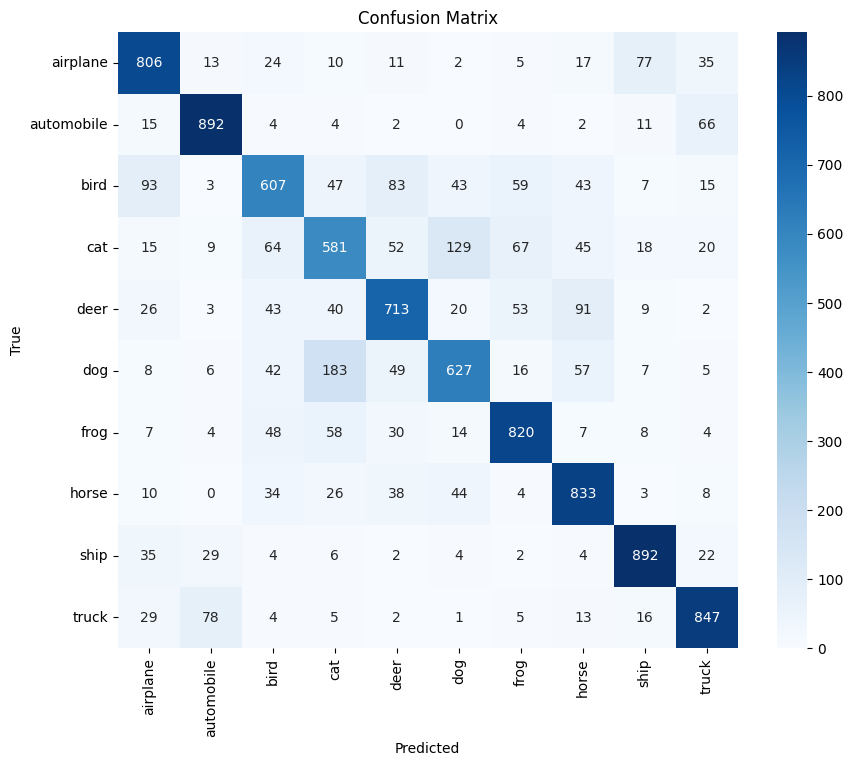

Classification Report:

              precision    recall  f1-score   support

    airplane       0.77      0.81      0.79      1000
  automobile       0.86      0.89      0.88      1000
        bird       0.69      0.61      0.65      1000
         cat       0.61      0.58      0.59      1000
        deer       0.73      0.71      0.72      1000
         dog       0.71      0.63      0.67      1000
        frog       0.79      0.82      0.81      1000
       horse       0.75      0.83      0.79      1000
        ship       0.85      0.89      0.87      1000
       truck       0.83      0.85      0.84      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



In [10]:
# =====================
# Confusion Matrix
# =====================
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(true_labels, predictions, target_names=train_dataset.classes))

In [11]:
#classfication report without sklearn:

def calculate_metrics(actual_labels, predicted_labels, num_classes=10):
    # Initialize counts
    true_positive = [0] * num_classes
    false_positive = [0] * num_classes
    false_negative = [0] * num_classes

    # Populate TP, FP, FN for each class
    for i in range(len(actual_labels)):
        true_label = int(actual_labels[i])
        pred_label = int(predicted_labels[i])
        if true_label == pred_label:
            true_positive[true_label] += 1
        else:
            false_positive[pred_label] += 1
            false_negative[true_label] += 1

    # Calculate precision, recall, and F1-score for each class
    precision = []
    recall = []
    f1_score = []

    for i in range(num_classes):
        tp = true_positive[i]
        fp = false_positive[i]
        fn = false_negative[i]

        # Precision: TP / (TP + FP)
        p = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        precision.append(p)

        # Recall: TP / (TP + FN)
        r = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        recall.append(r)

        # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
        f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0.0
        f1_score.append(f1)

    # Calculate macro-average
    macro_precision = sum(precision) / num_classes
    macro_recall = sum(recall) / num_classes
    macro_f1 = sum(f1_score) / num_classes

    # Print results
    print("Class\tPrecision\tRecall\t\tF1-Score")
    for i in range(num_classes):
        print(f"{i}\t{precision[i]:.2f}\t\t{recall[i]:.2f}\t\t{f1_score[i]:.2f}")

    print("\nMacro-Average Metrics:")
    print(f"Precision: {macro_precision:.2f}")
    print(f"Recall: {macro_recall:.2f}")
    print(f"F1-Score: {macro_f1:.2f}")

    return precision, recall, f1_score, macro_precision, macro_recall, macro_f1




# Assuming act_labels and model_predicted are tensors from the test phase
precision, recall, f1_score, macro_precision, macro_recall, macro_f1 = calculate_metrics(
    true_labels, predictions, num_classes=10
)

Class	Precision	Recall		F1-Score
0	0.77		0.81		0.79
1	0.86		0.89		0.88
2	0.69		0.61		0.65
3	0.61		0.58		0.59
4	0.73		0.71		0.72
5	0.71		0.63		0.67
6	0.79		0.82		0.81
7	0.75		0.83		0.79
8	0.85		0.89		0.87
9	0.83		0.85		0.84

Macro-Average Metrics:
Precision: 0.76
Recall: 0.76
F1-Score: 0.76
